# IMPORTS

## Libraries

In [3]:
import warnings

import numpy  as np
import pandas as pd

import seaborn           as sns
import matplotlib.pyplot as plt

from scipy import stats as ss

from IPython.display      import Image
from IPython.core.display import HTML

# data balancing
from imblearn.combine        import SMOTETomek
# feature selection
from boruta                  import BorutaPy

from lightgbm                import LGBMClassifier
from sklearn.metrics         import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Load Dataset

In [4]:
dfRawTrain = pd.read_feather('00-Data/FeatherData/trainDatasetScaling.feather')

## Helper Functions

#### Jupyter Settings

In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    seed = 0
    np.random.seed(seed)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [6]:
jupyter_settings()  

Populating the interactive namespace from numpy and matplotlib


#### Functions

In [8]:
def mlScores(modelName, y, yhat, yhatProba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    ap = average_precision_score(y, yhatProba)
    rocauc = roc_auc_score(y, yhatProba)
    
    return pd.DataFrame({ 'Model Name': modelName, 
                           'Precision': precision, 
                           'Recall': recall,
                           'F1 Score': f1,
                           'Kappa': kappa,
                           'Average Precision Score': ap,
                           'ROC AUC': rocauc}, index=[0])



def crossValidation(XTraining, kfold, modelName, model, verbose=False):
    precisionList = []
    recallList = []
    f1List = []
    kappaList = []
    apList = []
    rocaucList = []
    XTraining = XTraining.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # Filtering Dataset
        training = XTraining.iloc[0: k*(round(XTraining.shape[0]/(kfold+1))), :]
        validation = XTraining.iloc[k*(round(XTraining.shape[0]/(kfold+1))) : (k+1)*(round(XTraining.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        XKFoldTraining = training.drop(['Exited'], axis=1)
        yKFoldTraining = training['Exited']

        # Validation
        XKFoldValidation = validation.drop(['Exited'], axis=1)
        yKFoldValidation = validation['Exited']
        
        # set the resampler
#         resampler = SMOTETomek(random_state=42, n_jobs=-1)
#         # resample the dataset
#         XKFoldTrainingBalanced, yKFoldTrainingBalanced = resampler.fit_resample(XKFoldTraining, yKFoldTraining)
#         XKFoldValidationBalanced = XKFoldValidation
#         yKFoldValidationBalanced = yKFoldValidation
        #XKFoldValidationBalanced, yKFoldValidationBalanced = resampler.fit_resample(XKFoldValidation, yKFoldValidation)
        
        #Model
        model.fit(XKFoldTraining, yKFoldTraining)

        # Prediction
        yhat = model.predict(XKFoldValidation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(XKFoldValidation)[:,1]

        #Performance
        modelResult = mlScores(modelName, yKFoldValidation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precisionList.append(modelResult['Precision'].tolist())
        recallList.append(modelResult['Recall'].tolist())
        f1List.append(modelResult['F1 Score'].tolist())
        kappaList.append(modelResult['Kappa'].tolist())
        apList.append(modelResult['Average Precision Score'].tolist())
        rocaucList.append(modelResult['ROC AUC'].tolist())
    

    dictResult = {
                    'Model Name': [modelName],
                    'Precision CV': [np.round(np.mean(precisionList),2).astype(str) + ' +/- ' + np.round(np.std(precisionList),2).astype(str)],
                    'Recall CV': [np.round(np.mean(recallList),2).astype(str) + ' +/- ' + np.round(np.std(recallList),2).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1List),2).astype(str) + ' +/- ' + np.round(np.std(f1List),2).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappaList),2).astype(str) + ' +/- ' + np.round(np.std(kappaList),2).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(apList),2).astype(str) + ' +/- ' + np.round(np.std(apList),2).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(rocaucList),2).astype(str) + ' +/- ' + np.round(np.std(rocaucList),2).astype(str)]
                }

    return pd.DataFrame(dictResult)

# Modelling

In [10]:
df07 = dfRawTrain.copy()

In [11]:
colsSelectedBoruta = ['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'AgeGroup_Midlife']

## X,y Split

In [12]:
# Train
yTrain = df07['Exited']
XTrain = df07[colsSelectedBoruta]

# set the resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)
# resample the dataset
XBalanced, yBalanced = resampler.fit_resample(XTrain, yTrain)

dfTrain = pd.concat([XBalanced, yBalanced], axis=1)

In [13]:
dfTrain.sample(frac=1).reset_index(drop=True)

Age   Balance  NumOfProducts  EstimatedSalary  AgeGroup_Midlife  Exited
0      0.635135  0.426021       0.333333         0.034596                 0       0
1      0.567568  0.212906       0.000000         0.706833                 1       1
2      0.270990  0.322418       0.000000         0.246992                 0       1
3      0.364865 -0.761735       0.000000         0.054489                 0       0
4      0.455010  0.426251       0.000000         0.068477                 1       1
5      0.378378 -0.761735       0.000000         0.104983                 1       1
6      0.391892  0.065321       0.333333         0.786822                 1       0
7      0.162162 -0.761735       0.666667         0.846807                 0       1
8      0.391892 -0.761735       0.333333         0.727981                 1       0
9      0.216216  0.178220       0.333333         0.001659                 0       0
10     0.297297  0.138449       0.333333         0.974513                 0       1
11     0.189189  0.642534       0.000000         0.745232                 0       0
12     0.472973 -0.405608       0.000000         0.205240                 1       1
13     0.300923 -0.761735       0.000000         0.287762                 0       1
14     0.312912  0.029861       0.000000         0.647714                 0       1
15     0.224230 -0.361310       0.000000         0.562975                 0       1
16     0.621622 -0.761735       0.333333         0.376341                 0       0
17     0.397424  0.247143       0.000000         0.861611                 1       1
18     0.770270 -0.761735       0.333333         0.046831                 0       0
19     0.513514 -0.761735       0.333333         0.208876                 1       0
20     0.592692  0.018434       0.000000         0.417640                 0       1
21     0.511287  0.443454       0.000000         0.581367                 1       1
22     0.405405  0.234884       0.000000         0.460707                 1       1
23     0.337838  0.181845       0.000000         0.474363                 0       1
24     0.465028  0.254721       0.000000         0.955033                 1       1
25     0.587432 -0.761735       0.000000         0.642278                 0       1
26     0.337838 -0.761735       0.000000         0.996491                 0       1
27     0.162162  0.359290       0.333333         0.014721                 0       0
28     0.500000 -0.042051       0.000000         0.724363                 1       1
29     0.216216 -0.761735       0.333333         0.131260                 0       0
30     0.254497 -0.761735       0.000000         0.609301                 0       1
31     0.390890  0.169442       0.333333         0.879856                 1       1
32     0.162162  0.180853       0.000000         0.688975                 0       0
33     0.175676 -0.761735       0.333333         0.165372                 0       0
34     0.270270 -0.761735       0.333333         0.472065                 0       0
35     0.310811  0.406411       0.333333         0.210619                 0       1
36     0.418919 -0.761735       0.000000         0.740452                 1       1
37     0.364865  0.264520       0.000000         0.370003                 0       1
38     0.350180 -0.761735       0.695567         0.313623                 0       1
39     0.223336 -0.761735       0.000000         0.386332                 0       1
40     0.216216 -0.761735       0.333333         0.579208                 0       0
41     0.325431  0.423699       0.000000         0.199465                 0       1
42     0.391892 -0.761735       0.333333         0.989846                 1       0
43     0.435591  0.069056       0.000000         0.834529                 1       1
44     0.216216 -0.048847       0.333333         0.818935                 0       0
45     0.475200  0.198611       0.000000         0.038108                 1       1
46     0.391892  0.188850       0.333333         0.272336       

## Data Balancing

Text(0.5, 1.0, 'After SMOTE')

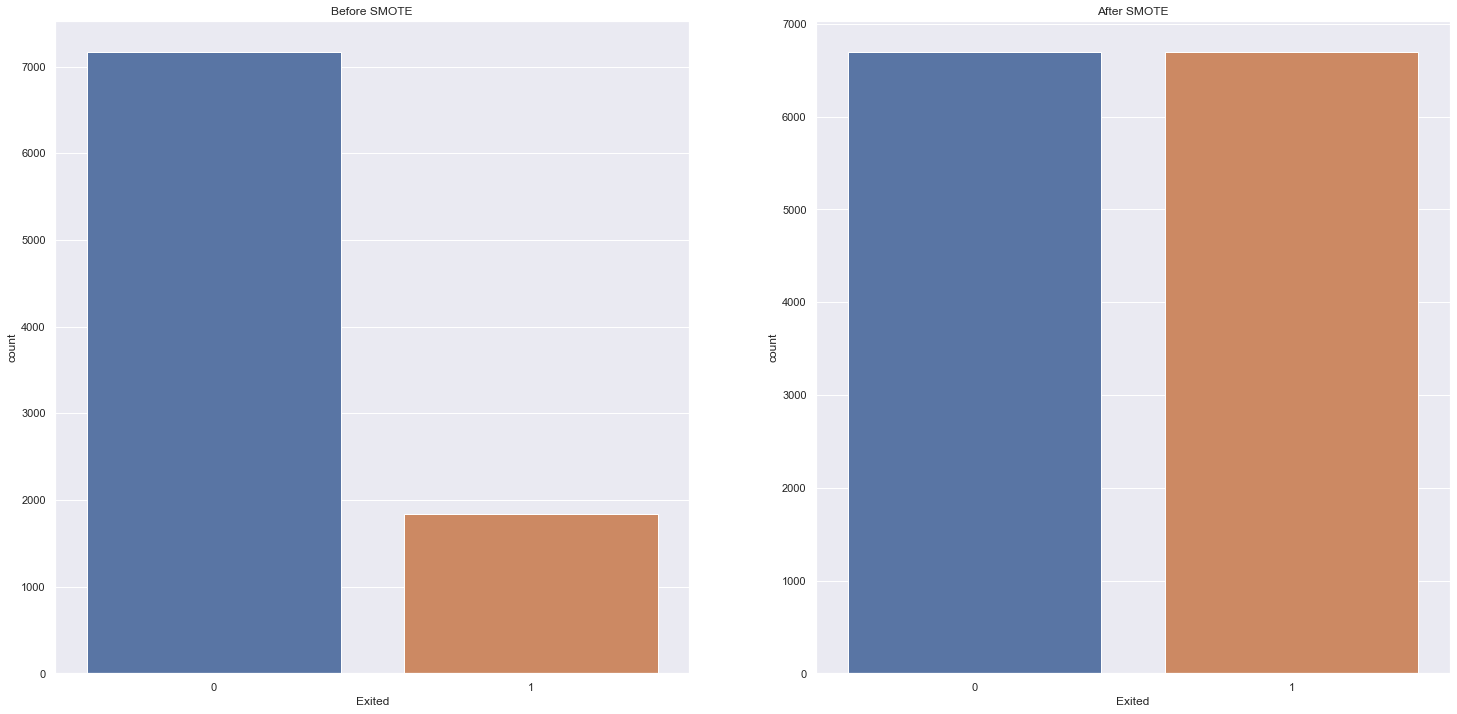

In [14]:
# plots before and after SMOTE
plt.subplot(1,2,1)
sns.countplot(x=yTrain);
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=yBalanced);
plt.title("After SMOTE")

# MODELS

## Logistic Regression

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(dfTrain.drop(['Exited'], axis=1), dfTrain['Exited'], test_size=.1, stratify=dfTrain['Exited'])


model = LogisticRegression()
#Model
model.fit(X_train, y_train)

# Prediction
yhat = model.predict(X_valid)

# Prediction Proba
yhatProba = model.predict_proba(X_valid)[:,1]

mlScores(model, y_valid, yhat, yhatProba)

Model Name  Precision    Recall  F1 Score     Kappa  Average Precision Score  ROC AUC
0  LogisticRegression()   0.763485  0.549254  0.638889  0.378771                 0.772677  0.77889

In [16]:
modelLr = LogisticRegression()
# Performance
modelLrResult = crossValidation(dfTrain, 10, 'Logistic Regression', modelLr, verbose=False)
modelLrResult.head()

Model Name   Precision CV      Recall CV    F1 Score CV       Kappa CV Average Precision Score CV     ROC AUC CV
0  Logistic Regression  0.76 +/- 0.01  0.55 +/- 0.02  0.64 +/- 0.02  0.38 +/- 0.02              0.75 +/- 0.01  0.77 +/- 0.01

## Lightgbm Classifier

In [17]:
modelLGBM = LGBMClassifier(max_depth=2, min_data_in_leaf=50, n_jobs=-1, random_state=42, n_estimators=500)
# Performance
modelLGBMResult = crossValidation(dfTrain, 10, 'Lightgbm Classifier', modelLGBM, verbose=False)
modelLGBMResult.head()

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min

Model Name   Precision CV      Recall CV    F1 Score CV       Kappa CV Average Precision Score CV     ROC AUC CV
0  Lightgbm Classifier  0.86 +/- 0.03  0.83 +/- 0.02  0.84 +/- 0.02  0.69 +/- 0.04              0.92 +/- 0.02  0.92 +/- 0.02

## Random Forest Classifier

In [ ]:
modelRf = RandomForestClassifier(max_depth=2, min_samples_leaf=50, n_jobs=-1, random_state=42, n_estimators=500)
# Performance
modelRfResult = crossValidation(dfTrain, 10, 'Random Forest Classifier', modelRf, verbose=False)
modelRfResult.head()

Model Name   Precision CV      Recall CV    F1 Score CV       Kappa CV Average Precision Score CV     ROC AUC CV
0  Random Forest Classifier  0.74 +/- 0.02  0.75 +/- 0.04  0.74 +/- 0.02  0.48 +/- 0.03              0.82 +/- 0.02  0.82 +/- 0.01

## XGBoost Classifier

In [ ]:
from xgboost  import XGBClassifier
modelXGB = XGBClassifier(max_depth=2, n_jobs=-1, random_state=42, n_estimators=500)
# Performance
modelRfResult = crossValidation(dfTrain, 10, 'XGBoost Classifier', modelXGB, verbose=False)
modelRfResult.head()